# Diagnóstico del muestreo

In [1]:
import arviz as az
import pymc as pm
import preliz as pz
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as ipyw
from IPython.display import IFrame

In [2]:
az.style.use('arviz-doc')

Los objetivos de este capítulo son:

* Obtener nociones básicas de métodos de Markov Chain Monte Carlo y su rol en estadística Bayesiana

* Discutir algunos de los métodos de diagnóstico del muestreo más usados

## Revisitando el teorema de Bayes

El teorema de Bayes, tiene una formulación que a primera vista parece muy inocente. Tan solo cuatro términos relacionados por una multiplicación y una división.

$$
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}
$$

Pareciera que no sirve de mucho y que es fácil de calcular. Sin embargo, ambas apreciaciones son incorrectas. El resto de los capítulos se centran en mostrar contra ejemplos a la primera aseveración, así que veamos por que a veces su cálculo puede ser difícil y se requieren métodos numéricos.

La razón está en el cálculo del likelihood marginal. El cual toma la forma de una integral.

$$
{p(\boldsymbol{Y}) = \int_{\boldsymbol{\Theta}} p(\boldsymbol{Y} \mid \boldsymbol{\theta})p(\boldsymbol{\theta}) d\boldsymbol{\theta}}
$$

Esta integral suele ser difícil de resolver. Veamos, esta expresión nos dice que debemos evaluar el likelihood para cada uno de los posibles valores del prior $\theta$. En la práctica esa tarea no siempre es sencilla o barata de realizar. Si $\theta$ representa un solo parámetro desconocido (como en el modelo beta-binomial) entonces solo hay que resolver una integral, pero si $\theta$ representa dos parámetros (como en el modelo Gaussiano) entonces la integral será doble. En definitiva la integral tendrá tantas dimensiones como parámetros el modelo. En general las integrales en grandes dimensiones no son simples de resolver.

Algo que puede ser poco intuitivo es que esto se contrapone con el cálculo de la distribución a posteriori. Para obtener una buena aproximación a la distribución a posteriori bastaría con concentrarse en las regiones donde tanto la contribución del prior como del likelihood son *relativamente grandes* (área gris en la siguiente figura), en general esto es lo que hacen la mayoría de los métodos numéricos. En cambio esta misma aproximación puede conducir a errores en el cálculo del likelihood marginal


<center><img src="img/grid.png" width=800></center>


Para algunos problemas es posible calcular la distribución a posteriori de forma analítica. Esto ya lo vimos para el modelo beta-binomial donde la posterior es:


$$
p(\theta \mid y) \propto \operatorname{Beta}(\alpha_{a priori} + y, \beta_{a priori} + N - y)
$$

Para esos casos suele ser posible también calcular el marginal likelihood de forma analítica.

Pero en general no tenemos expresiones analíticas y entonces debemos confiar en métodos numéricos.

## Calculando la distribución a posteriori

Hay muchas formas de calcular la distribución a posteriori

 * <font color = gray> Conjugación </font>
 * <font color = gray> Método de Laplace </font>
 * <font color = gray> Aproximación de Laplace Anidada Integrada (INLA) </font>
 * <font color = gray> Inferencia Variacional (VI) </font>
 * Markov Chain Monte Carlo (MCMC)
 * <font color = gray> Sequential Monte Carlo </font>
 * ...


Por ahora solo hablaremos de los métodos MCMC ya que, por el momento, son los métodos más generales. Pero para entender de forma más simple que es lo que hacen estos métodos conviene empezar desde otro método, conocido como método de la grilla.

### Método de la grilla

El método de grilla es un enfoque simple de fuerza bruta. La idea central es que incluso si no somos
capaces de calcular todo la distribución a posteriori, en general si somos capaces de evaluar el
a priori y el likelihood punto-a-punto.

Para un modelo con un solo parámetro el método de la grilla se puede resumir de la siguiente forma:

* Encuentre un intervalo razonable para el parámetro (el prior debe dar algunas pistas).

* Defina una grilla de puntos (generalmente equidistantes) en ese intervalo.

* Para cada punto de la grilla, evalúe el prior y el likelihood en ese punto y multiplique


La siguiente figura ilustra este método


<center><img src="img/grid.gif" width=800></center>


El siguiente bloque de código (que ya usamos antes) implementa un método de la grilla interactivo 

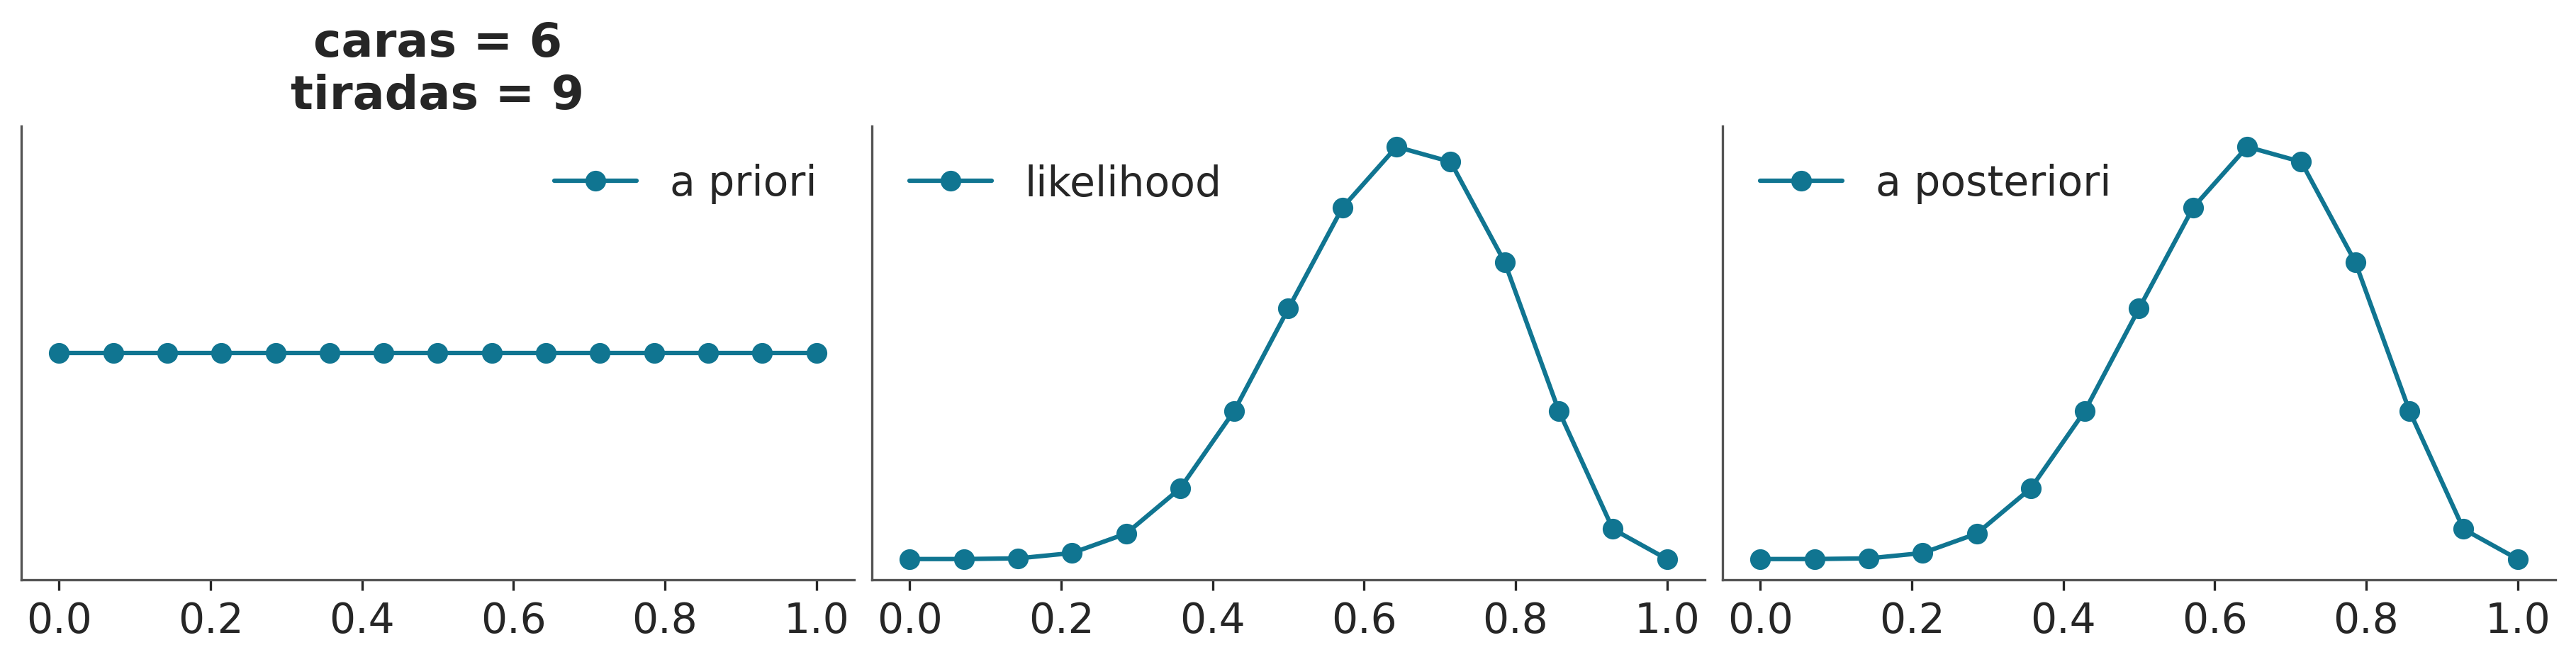

interactive(children=(IntSlider(value=15, description='grilla', min=2), FloatSlider(value=1.0, description='a'…

In [3]:
def a_posteriori_grilla(grilla=10, a=1, b=1, caras=6, tiradas=9):
    grid = np.linspace(0, 1, grilla)
    prior = pz.Beta(a, b).rv_frozen.pdf(grid)
    likelihood = pz.Binomial(n=tiradas, p=grid).rv_frozen.pmf(caras)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    _, ax = plt.subplots(1, 3, sharex=True, figsize=(12, 3))
    ax[0].set_title('caras = {}\ntiradas = {}'.format(caras, tiradas))
    for i, (e, e_n) in enumerate(zip([prior, likelihood, posterior], ['a priori', 'likelihood', 'a posteriori'])):
        ax[i].set_yticks([])
        ax[i].plot(grid, e, 'o-', label=e_n)
        ax[i].legend()


interact(a_posteriori_grilla, grilla=ipyw.IntSlider(min=2, max=100, step=1, value=15), a=ipyw.FloatSlider(min=1, max=7, step=1, value=1), b=ipyw.FloatSlider(
    min=1, max=7, step=1, value=1), caras=ipyw.IntSlider(min=0, max=20, step=1, value=6), tiradas=ipyw.IntSlider(min=0, max=20, step=1, value=9));

Utilizando la función `a_posteriori_grilla` podemos comprobar que para obtener una mejor aproximación se puede aumentar el número de puntos de la cuadrícula. Esta estrategia puede ser útil en unas pocas dimensiones (parámetros). Pero no escala. En la siguiente figura vemos que si necesitamos 4 puntos en 1D, para mantener ese mismo grado de precisión necesitaremos 16 puntos en 2D y 64 en 3D. La velocidad con la que crecen la cantidad de evaluaciones necesarias crece demasiado rápido, una grilla de 100 en 10 dimensiones requeriría de 1e+20 puntos! 

<center><img src="img/grid_dimensions.png" width=800></center>

Como si eso no fuera poco, la cosa es más complicada. En espacios de alta dimensión se dan una serie de fenómemos conocidos como **concentración de la medida** o en versión marketinera la **maldición de la dimensionalidad** 👻. Por ejemplo:

* En una hiper-esfera casi todo el volumen está en la superficie. Es decir, si uno pelara una hiper-naranja se quedaría con hambre!

* En un hiper-cubo la masa se concentra en las esquinas
 
* En una Gaussiana hiper-dimensional casi toda la masa está lejos de la moda

La idea de estimar la distribución a posteriori evaluando, punto a punto,  likelihood y prior es muy buena, pero la idea de construir una grilla predefinida solo funciona en muy bajas dimensiones.

Pero no todo está perdido, que tal si mantenemos la idea de la evaluación puntual, pero nos concentramos en las *regiones que importan*?

### Markov Chain Monte Carlo (MCMC)

Esta es una familia muy extensa de métodos utilizados para resolver muchos problemas, entre los que se encuentra el cálculo de la distribución a posteriori. Conceptualmente se puede pensar a estos métodos como generalizaciones del método de la grilla, ya que también se basan en la posibilidad de realizar evaluaciones punto a punto del prior y likelihood. La diferencia crucial es que en vez de utilizar una grilla predefinida el método realiza evaluaciones que progresivamente se concentran en regiones de alta probabilidad. No solo eso si no que eventualmente el método devolverá muestras de forma proporcional a la probabilidad a posteriori. Es decir si una región es 3 veces más probable que otra obtendremos 3 veces más muestras de esa región que de la otra.

A muy grandes rasgos, y dado un punto inicial arbitrario, los métodos MCMC, constan de dos pasos. 

1. Generar un nuevo punto a partir de perturbar uno preexistente.
2. Aceptar o rechazar ese nuevo punto de forma probabilista y comparando la probabilidad del punto preexistente y del nuevo punto.

Esta es esencialmente la receta, la forma exacta en que hacemos cada uno de estos pasos define los distintos métodos dentro de la familia MCMC. Veamos uno de los más sencillos de entender y de implementar.

### Metropolis-Hastings

Metropolis-Hastings no es un algoritmo muy moderno o particularmente eficiente, pero Metropolis-Hastings es simple de entender y también proporciona una base para comprender métodos más sofisticados y poderosos. 

El algoritmo Metropolis-Hasting se define de la siguiente manera:

1. Inicialice el valor del parámetro $\boldsymbol{X}$ en $x_i$
2. Utilice una distribución de propuesta $q(x_{i + 1} \mid x_i)$ para generar un nuevo valor $x_{i + 1}$
3. Calcule la probabilidad de aceptar el nuevo valor como:

$$
p_a (x_{i + 1} \mid x_i) = \min \left(1, \frac{p(x_{i + 1}) \; q(x_i \mid x_{i + 1})} {p(x_i) \; q (x_{i + 1} \mid x_i)} \right)
$$

4. Si $p_a > R$ donde $R \sim \mathcal{U}(0, 1)$, guarde el nuevo valor; de lo contrario, guarde el anterior.
5. Iterar de 2 a 4 hasta que se haya generado una muestra *suficientemente grande*


El algoritmo Metropolis es muy general y se puede usar en aplicaciones no Bayesianas, pero para la presente discusión, $p(x_i)$ es la densidad del posterior evaluada en el valor del parámetro $x_i$. Una forma de simplificar un poco el método es notar que si $q$ es una distribución simétrica, los términos $q(x_i \mid x_{i + 1})$ y $q(x_{i + 1} \mid x_i)$ se cancelarán (conceptualmente significa que es igualmente probable que vayamos de $x_{i+1}$ a $x_i$ o de $x_{i}$ a $x_{i+1}$), dejando solo un cociente entre el posterior evaluado en dos puntos. Este algoritmo siempre aceptará moverse de una región de baja probabilidad a una más alta y aceptará probabilísticamente moverse de una región de alta a una baja probabilidad.

¡Otra observación importante es que el algoritmo Metropolis-Hastings no es un método de optimización! No nos importa encontrar el valor del parámetro con la máxima probabilidad, queremos _explorar_ la distribución $p$. Es decir aún si el método encuentra un máximo aún puede moverse a regiones de probabilidades más bajas.

Para hacer las cosas más concretas, intentemos resolver el modelo Beta-Binomial. 

\begin{aligned}
    \theta \sim &\; \text{Beta}(\alpha, \beta) \\
    Y \sim &\; \text{Bin}(n=1, p=\theta)
\end{aligned}

Este modelo tiene una solución analítica. Pero supongamos que no sabemos cómo calcular el posterior y, por lo tanto, implementaremos el algoritmo Metropolis-Hastings usando Python. 

In [4]:
def post(θ, Y, α=1, β=1):
    if 0 <= θ <= 1:
        prior = stats.beta(α, β).pdf(θ)
        like  = stats.bernoulli(θ).pmf(Y).prod()
        prob = like * prior
    else:
        prob = -np.inf
    return prob

También necesitamos datos, por lo que generaremos algunos datos falsos aleatorios para este propósito.

In [5]:
Y = stats.bernoulli(0.7).rvs(20)

Y finalmente ejecutamos nuestra implementación del algoritmo Metropolis-Hastings:

In [6]:
n_iters = 1000
can_sd = 0.05
α = β =  1
θ = 0.5 
trace = {"θ":np.zeros(n_iters)}
p2 = post(θ, Y, α, β)

for iter in range(n_iters):
    θ_can = stats.norm(θ, can_sd).rvs(1)
    p1 = post(θ_can, Y, α, β)  
    pa = p1 / p2

    if pa > stats.uniform(0, 1).rvs(1):
        θ = θ_can
        p2 = p1

    trace["θ"][iter] = θ

En la línea 9 del bloque de código anterior generamos una propuesta muestreando una distribución Normal con desviación estándar `can_sd`. En la línea 10 evaluamos el posterior en el nuevo valor generado `θ_can` y en la línea 11 calculamos la probabilidad de aceptación. En la línea 20 guardamos un valor de `θ` en el array `trace`.  Dependiendo del resultado de la comparación en la línea 13, el valor guardado será nuevo o repetiremos el anterior.

El primer panel de la siguiente figura muestra cada valor muestreado en cada paso, y el panel de la derecha el histograma de esos valores. El resultado parece razonable. Nada mal para unas pocas lineas de código!

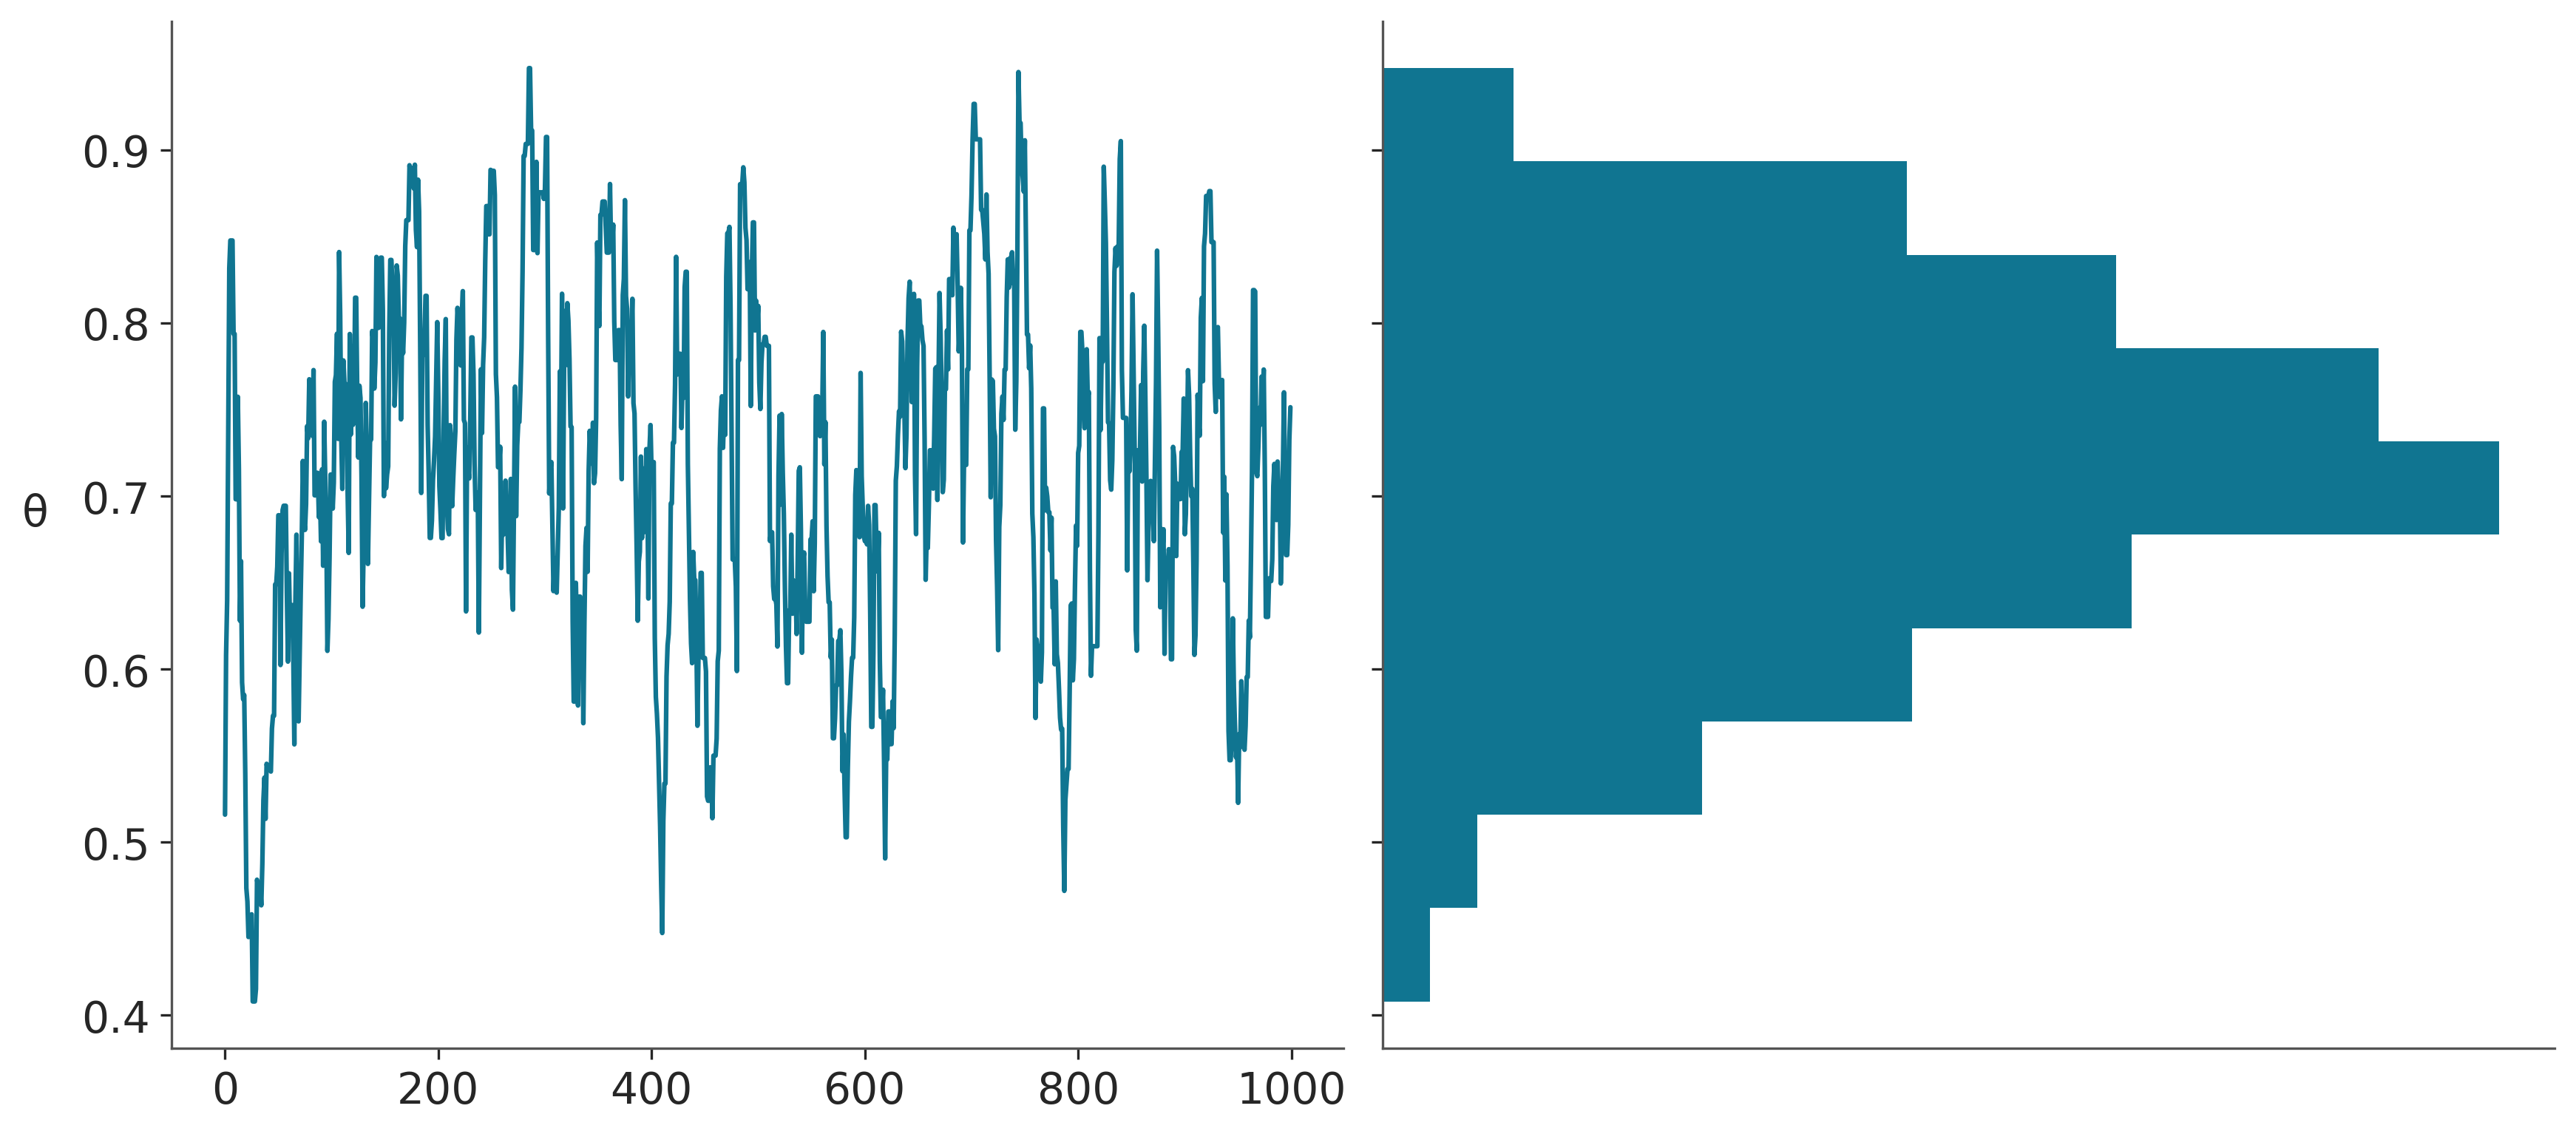

In [7]:
_, axes = plt.subplots(1,2, sharey=True)
axes[0].plot(trace['θ'])
axes[0].set_ylabel('θ', rotation=0, labelpad=15)
axes[1].hist(trace['θ'], orientation="horizontal", density=True)
axes[1].set_xticks([]);

[Acá](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana) pueden ver una versión interactiva de un Metropolis-Hastings

### MH adaptativo

En teoría, y si tomaramos infinitas muestras, cualquier distribución de propuesta sería útil. Sin embargo, en la práctica la eficiencia cambia drásticamente de acuerdoa la distribución de propuesta que utilicemos. Es por ello que para obtener un MH realmente eficiente es necesario ajustar hiperparámetros como la distribución de propuesta para cada problema. Esto se puede hacer dedicando una cierta cantidad de pasos (tuning), estos pasos luego se descartan

* Aún el RWMH adaptativo puede tener problemas para ciertas problemas
    * Parámetros muy correlacionados
    * Alta dimensión (muchos parámetros)
    * Geometrías complejas


Existen otras formas de generar aún mejores propuestas

### Montecarlo Hamiltoniano (HMC)

En vez de proponer nuevos puntos al azar podemos usar una analogía física. Simulamos una particula sin fricción que se mueve por la distribución a posteriori. Esto se puede hacer si conocemos el Hamiltoniano del sistema. En términos simples, un hamiltoniano es una descripción de la energía total de un sistema físico. 


$$
\underbrace{H(\overbrace{\mathbf{q}}^{\text{posición}}, \overbrace{\mathbf{p}}^{\text{momemtum}})}_{\text{Hamiltoniano}}  = \underbrace{K(\mathbf{p}, \mathbf{q})}_{\text{Energía cinética}} + \underbrace{V(\mathbf{q})}_{\text{Energía potencial}}
$$

La posición $q$ se corresponde con los valores que puedan tomar los parámetros del modelo probabilista y la energía potencial es la probabilidad a posteriori de esos valores. El momentum, en cambio, lo sacamos de la galera. Es simplemente una variable auxiliar que nos permite calcular el hamiltoniano y "mover" el sistema.

Entonces, a grandes rasgos un HMC tiene dos pasos que se repiten hasta obtener la cantidad de muestras necesarias:

1. Generar un nuevo punto a partir del hamiltoniano
2. Aceptar o rechazar ese nuevo punto de forma probabilista y comparando la probabilidad del punto preexistente y del nuevo punto.

Por qué es buena idea usar el hamiltoniano? En un MH la propuesta es aleatoria, es como querer encontrar algo en una habitación desconocida a oscuras, hay que ir a tientas. Mientras que con el Hamiltoniano es como tener una linterna, ahora podemos ver que hay en la habitación, al menos localmente a donde apuntemos con la linterna. Veamos, una explicación un poco más matemática. Resolver el hamiltoniano implica calcular derivadas, las derivadas nos dan información sobre la curvatura de una función, por ejemplo el cálculo de la primer derivada en un punto nos dice hacia donde (de)crece una función. Si siquieramos la derivada buscando, hacia donde crece la función, eventualmente llegariamos a un máximo (asumiendo que este existe). Esto se llama maximizar una función. Al agregar el *momemtum* podemos hacer algo más interesante, podemos simular un trayectoria que explore la distribución a posteriori. Esto es importante en estadística Bayesiana, ya que no solo queremos el máximo, si no una descripción de toda la distribución a posteriori.


<center><img src="diapo/img/hmc_landscape.gif" width=700></center>

Un HMC tiene varios hipeparámetros, por ejemplo para simular una trayectoria tenemos que hacerlo de a pasos discretos, mientras más pequeños los pasos más fidedigna la simulación, pero también más costosa. Otro hiperparámetro es la longitud de cada simulación si esta es muy corta demoraremos mucho tiempo en explorar la distribución a posteriori, pero si está es muy larga corremos el riesgo de volver al mismo lugar.

En la siguiente figura se muestran tres ejemplos. A la izquierda el paso es muy corto, por lo que la exploración no es eficiente, en el centro el paso es correcto pero la simulación demasiado larga, tanto que volvemos al punto de partida, a la derecha tanto el paso como el tiempo de simulación son adecuamos y la propuesta genera un punto alejado en el espacio de los parámetros, pero con alta probabilidad de aceptación. De hecho en este ejemplo la probabilidad de aceptación es 1, ya que la pdf es la misma para el punto de partida que para el punto final.

<center><img src="img/hmc_1D.gif" width=900></center>

Este es otro ejemplo, en cada caso se muestra una densidad de probabilidad que va de más probable (amarillo) a menos probable (violeta), las flechas naranjas indican la trayectoria calculada de a pasos. En en el primero caso vemos una trayectoria elíptica tan larga que vuelve al punto de partida. En el segundo ejemplo vemos que el paso no es adecuado, esto produce una simulación inestable que se manifiesta en **divergencias** de la trayectoria correcta. En este último caso, y como en el ejemplo anterior, vemos que tanto el paso como el tiempo de simulación son adecuamos y la propuesta genera un punto alejado en el espacio de los parámetros, pero con alta probabilidad de aceptación (1 en este caso).


<center><img src="diapo/img/HMC_trayectoria.png" width=900></center>


Cuando los hiper-parámetros de un HMC son adecuados, el muestreo es muy eficiente, mucho más eficiente que un MH. Los valores de los hiper-parámetros dependen esencialmente de la geometría de la distribución a posteriori, por lo que no existe un solo conjunto de hiper-parámetros mejor que los demás. Es por ello que en la práctica estos se calculan de forma adaptativa corriendo una cantidad de pasos de HMC los cuales se utilizan para ajustar eso hiper-parámetros automáticamente y luego se descartan. NUTS (No U-Turn sampler), el sampler por defecto en PyMC es un HMC dinámico y adaptativo. El nombre proviene de una rutina del método que evita que las trayectorias den vueltas en U. 

## Diagnósticos generales

Asintóticamente los MCMC ofrencen la respuesta correcta, el problema es que asintóticamente estamos todos muertos! En la práctica sea hace necesario contar con métodos de diagnóstico que permitan evaluar si el muestreo es correcto para muestras finitas. Si nos ponemos en pesimistas este es un problema sin solución, ya que es imposible demostrar que una muestra es correcta, solo podemos probar que NO lo es. Entonces lo que buscamos es poder recolectar evidencia a favor de la ausencia de problemas. Esto nos va a conducir a establecer algunos valores umbrales, es decir si el diagnositico $D$ da un valor superior a $m$, tenemos un problema con nuestra muestra. Esto también es problemático, ya que establecer umbrales estrictos es en general arbitrario, salvo para casos triviales. Supongamos que yo me invento un diagnóstico para la calvice. El método es simple, hay que contar pelos. Es claro que 0 pelos corresponde a un pelado y 150.000 no, ya que esto se estima como la cantidad de pelos promedio en una cabeza promedio (sea lo que eso sea). Pero que pasa si alguien tiene 122 o 4126 pelos? A continuación veremos algunos valores umbrales, es importante entonces tomarlos con pinzas.



### En la teoría confiamos
  
La teoría describe cierto comportamiento de los MCMC, muchos diagnósticos están basados en evaluar si los resultados teóricos se verifican empíricamente. Por ejmplo, la teoría de MCMC dice que:


* El valor inicial es irrelevante, siempre debemos llegar al mismo resultado
* Las muestras no son realmente independientes, pero el valor de un punto solo depende del punto anterior, no hay correlaciones de largo alcance.
* Si miramos la muestra como una secuencia no deberíamos ser capaces de encontrar patrón alguno
    * Por ej, para una muestra lo suficientemente larga, la primera porción debe ser indistinguible de la última (y la mismo cualquier otra combinación de regiones).
* Para un mismo problema cada muestra generada va a ser diferente de las otras, pero a los fines prácticos las muestras deberían ser indistinguibles unas de otros

### Trace plots

Este es un gráfico muy común. Para cada parámetro graficamos su valor (eje-y) en cada iteración (eje-x). Lo esperable es no ver ningún patrón, solo ruido como en primer panel de la siguiente figura (marco turquesa).

<center><img src=diapo/img/trace_single_good_bad.png width=800></center>

En cambio los otros tres paneles (marco magenta) muestran problemas. De izquierda a derecha y arriba a abajo:

* El segundo panel muestra que el muestreo es "pegajoso", le toma muchos pasos a la cadena moverse de valores altos a valores bajos, es difícil predecir que sucedería si sequimos corriendo, la cadena se movería hacia arriba nuevamente, se estabilizaría en valos bajos, continuaría bajando aún más?

* El tercer panel muestra una cadena menos "pegajosa", pero también daría la impresión que aún no ha terminado de estabilizarse

* El último panel, en cambio, muestra que hay una región donde el sampler se mueve bien, pero cada tanto "salta" a estados donde se queda atascado. Quizá esto se deba a una distribución a posteriori multimodal o dificultades en el sampler para explorar regiones con distinta curvatura. 

Como ya vimos por defecto PyMC corre más de una cadena, por lo que un traceplot ideal debería verse como esto:


<center><img src=diapo/img/trace_multiple_good.png width=800/></center>


ArviZ permite graficar trace-plots usando la función `az.plot_trace()`. Por defecto obtenemos el trace a la derecha y un KDE (para variables continuas) y un histograma (para discretas) a la izquierda

<center><img src=diapo/img/trace_multiple_good_arviz.png width=900 /></center>


### Rank plots 

Los trace plots son muy comunes, pero existe una alternativa más moderna llamada rank plots. La idea básica es la siguiente. Para un parámetro tomamos todas las cadenas y ordenamos los valores de menor a mayor y les asignamos un rango es decir al valor más bajo le ponemos 1, al que sigue 0 y así hasta llegar a un número que será igual a la candidad de muestras totales (cantidad de cadenas multiplicado por la cantidad de muestras por cadena). Luego reagrupamos los rankings según las cadenas que les dieron origen y para cada cadena hacemos un histograma. Si las cadenas fuesen indistinguibles esperariamos que los histogramas sean uniformes. Ya que no hay razón para que una cadena tenga más rankings bajos (o medios o altos) que el resto.

La siguiente figura muestra 4 ejemplos, donde solo uno (marco cyan) no muestra problemas


<center><img src=diapo/img/rankbar_single_good_bad.png width=800></center>

En ArviZ los rank plots se pueden obtener con la función `az.plot_rank` o pasando un argumento a plot_trace `az.plot_trace(⋅, kind="rank_bars")`

### $\hat R$  (R sombrero)

Los gráficos suelen ser útiles para descrubir patrones, pero aveces queremos números, por ejmplo al evaluar rápidamente mucho parámetros. $\hat R$ es la respuesta a la pregunta. Lograron las cadenas mezclarse adecuadamente? Pero también me gusta pensalo como el jurado en un concurso de trace (o rank) plots. La versión implementada en ArviZ hace varias cosas debajo del capot, pero la idea central es que compara la varianza *entre* cadenas con la varianza *dentro* de cada cadena.


<center><img src="diapo/img/r_hat.gif" width=900></center>

Idealmente $\hat R =$1, en la práctica $\hat R \lessapprox 1.01$ son considerados seguros y en la primer fase de modelado valores más altos como $\hat R \approx 1.1$ pueden estár bien.

Usando ArviZ podemos obtener $\hat R$ usando `az.rhat(⋅)`, `az.summary(⋅)` y `az.plot_forest(⋅, r_hat=True)``

### Gráfico de autocorrelación

Idealmente, una muestra debe ser independiente e idénticamente distribuida (iid). Por definición, las muestras MCMC están correlacionadas. En la práctica, queremos muestras con baja autocorrelación. En ArviZ obtenemos este gráfico con la función `az.plot_autocorr()`

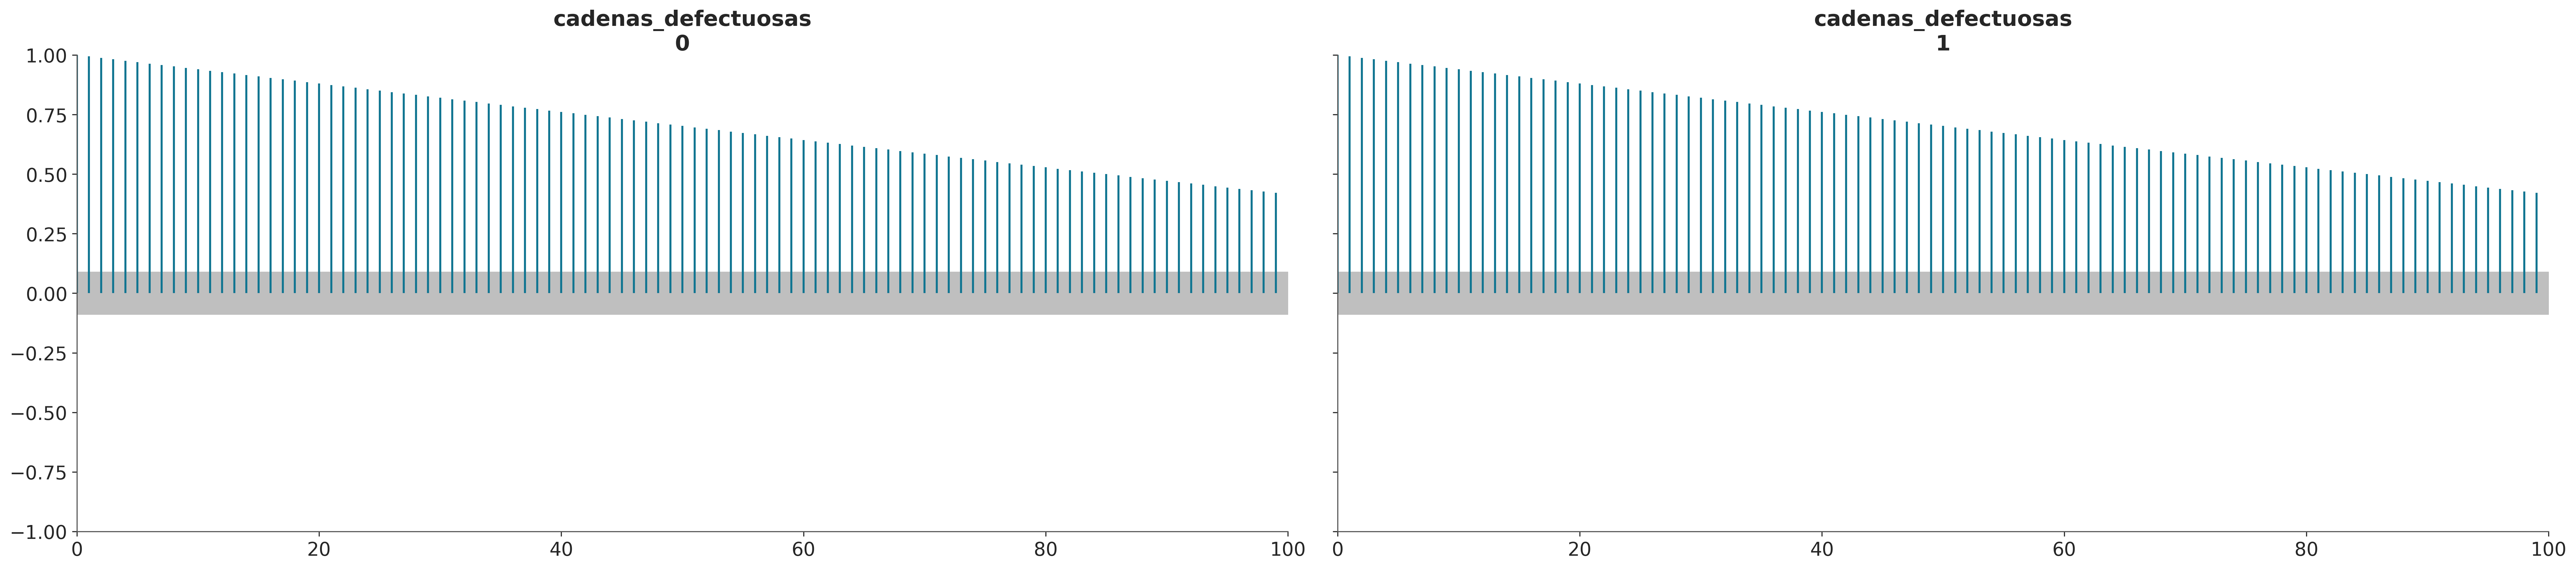

In [8]:
cadenas_defectuosas = {"cadenas_defectuosas": np.linspace(0, 1, 1000).reshape(2, -1)}
az.plot_autocorr(cadenas_defectuosas);

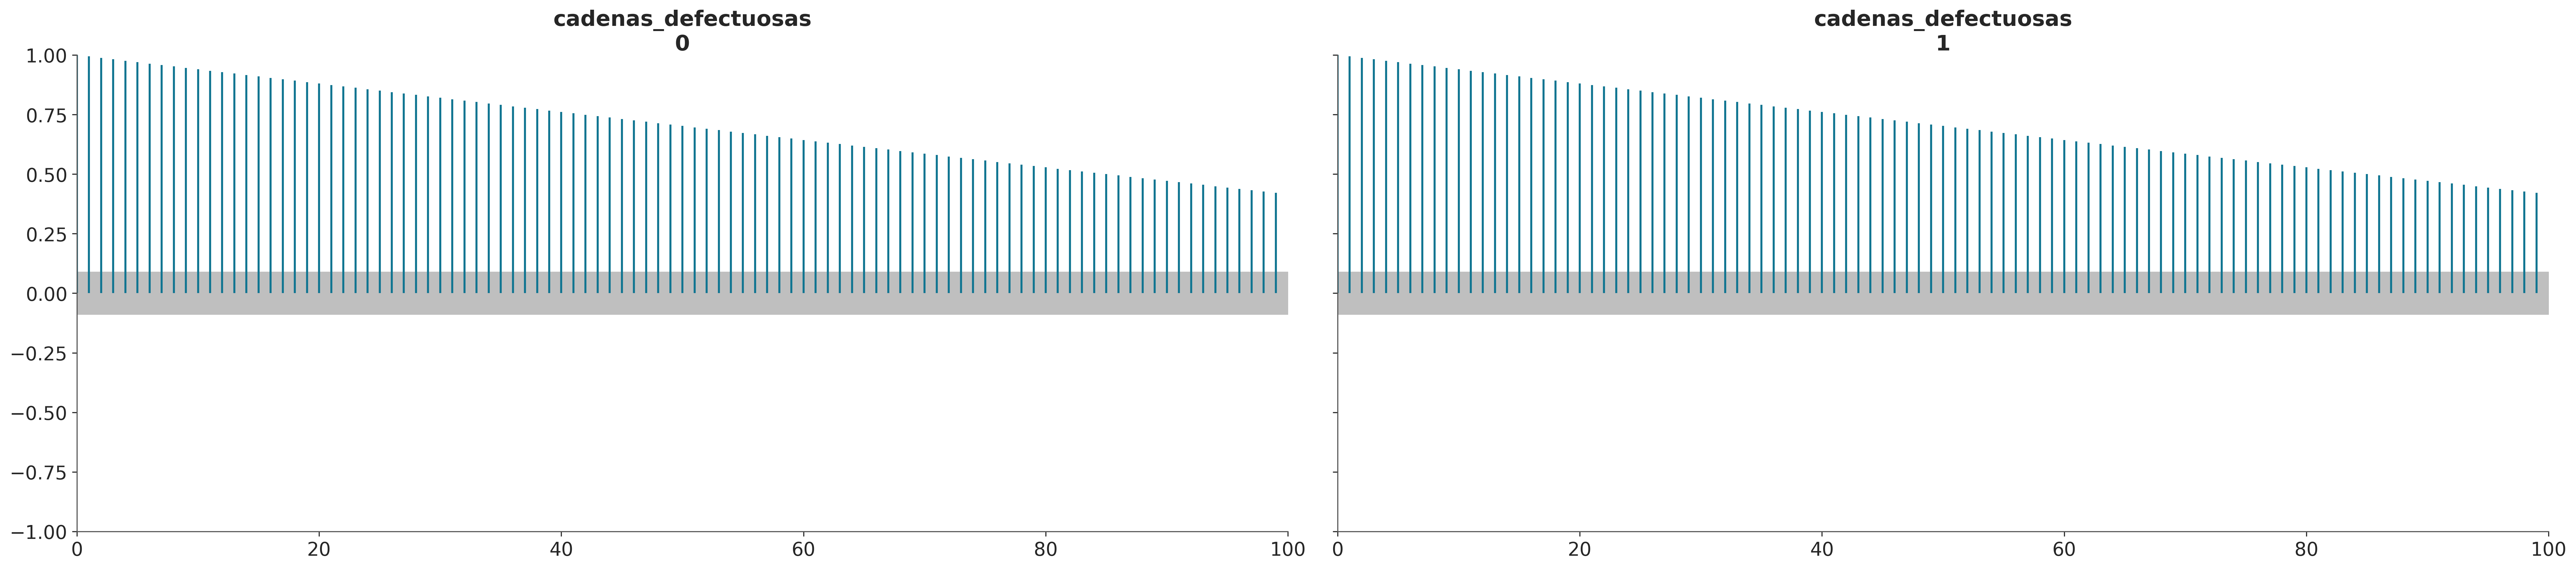

In [9]:
cadenas_defectuosas = {"cadenas_defectuosas": np.linspace(0, 1, 1000).reshape(2, -1)}
az.plot_autocorr(cadenas_defectuosas);

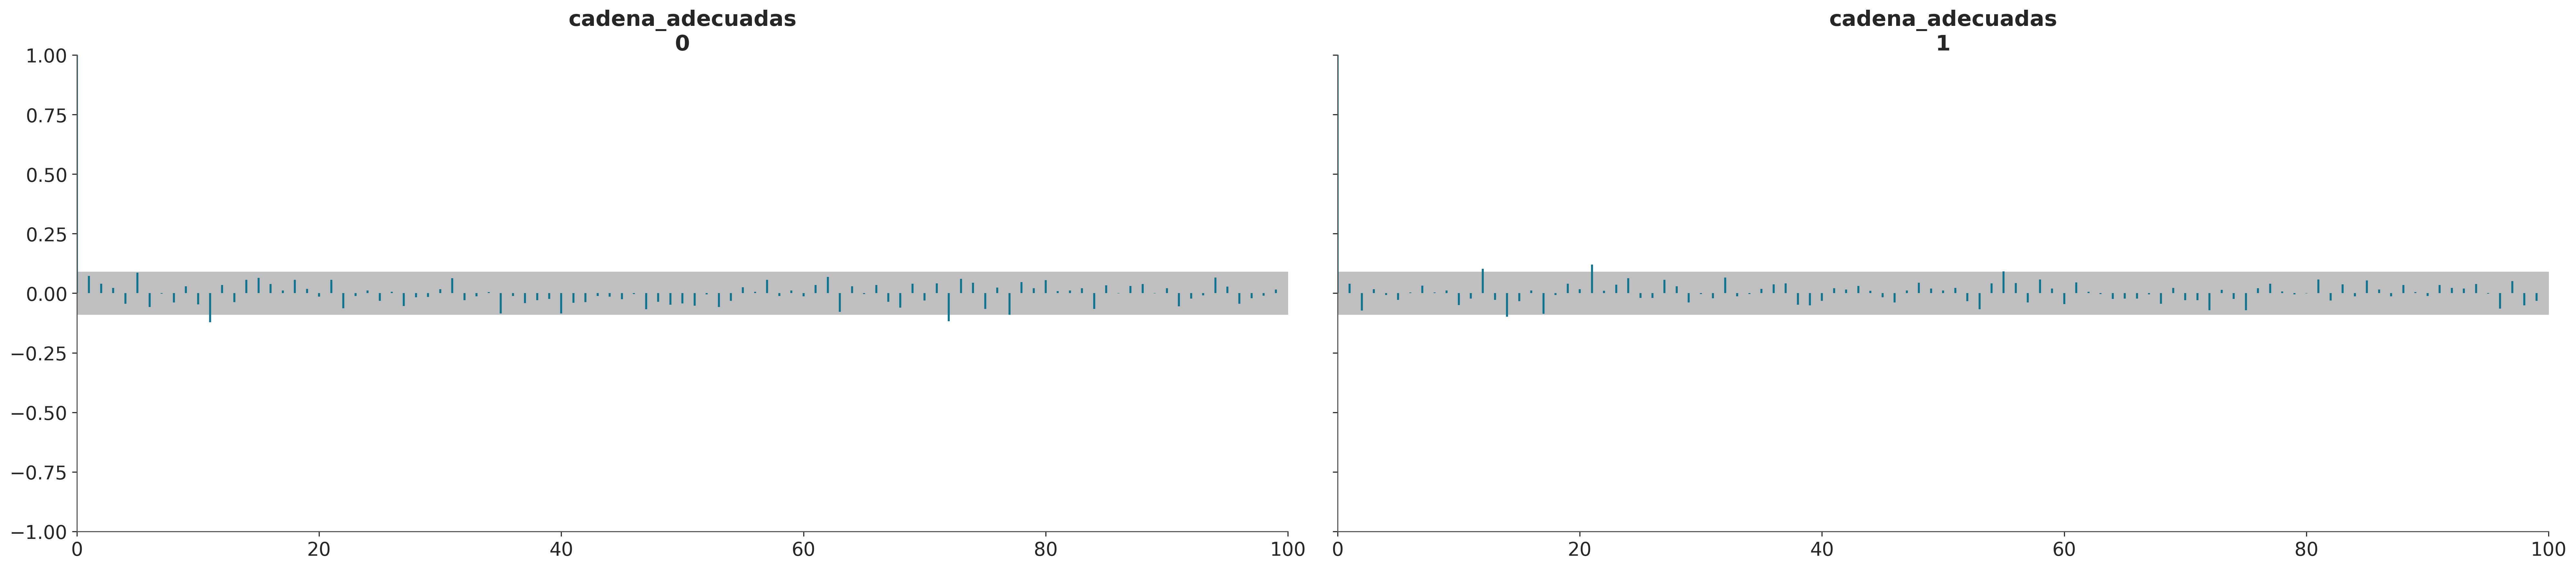

In [10]:
cadenas_adecuadas = {"cadena_adecuadas": pz.Uniform(0, 1).rvs(size=(2, 500))}
az.plot_autocorr(cadenas_adecuadas);

### Tamaño de muestra efectivo (ESS)

Como las muestras de un MCMC están correlacionadas la cantidad de información "útil" es menor que una muestra del mismo tamaño pero iid.

<br>
<br>
<center><img src="diapo/img/ess.gif" width=600></center>


Podemos estimar el **tamaño de muestra efectivo** (ESS), es decir, el tamaño de una muestra con la cantidad equivalente de información pero sin autocorrelación. Esto es útil para determinar si la muestra que tenemos es lo suficientemente grande. Se recomienta que el ESS sea superior a 100 por cadena. Es decir para para 4 cadenas queremos un mínimo de 400.

Con ArviZ podemos obtenerlo `az.ess(⋅)`, `az.summary(⋅)` y `az.plot_forest(⋅, ess=True)``

In [11]:
pd.concat((az.ess(cadenas_defectuosas).to_pandas(),
           az.ess(cadenas_adecuadas).to_pandas()))

cadenas_defectuosas      2.282878
cadena_adecuadas       910.058723
dtype: float64

Vemos que `az.summary(⋅)` devuelve dos valores de ESS, `ess_bulk` y `ess_tail`. Esto se debe a que, distintas regiones del espacio de los parámetros pueden tener distinto valor de ESS, ya que no todas las regiones son muestreadas con la misma eficiencia. Intuitivamente uno puede pensar que al muestrear una distribución como una Gaussiana es más fácil obtener mejor calidad de muestra alrededor de la media que de las colas, simplemente por que tenemos más muestras de esa región.

In [12]:
pd.concat([az.summary(cadenas_adecuadas, kind="diagnostics"),
           az.summary(cadenas_defectuosas, kind="diagnostics")])

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cadena_adecuadas,0.010,0.007,910.0,988.0,1.00
cadenas_defectuosas,0.198,0.165,2.0,11.0,3.05


Si las muestras de MCMC las vamos a usar para calcular valores centrales como medias o medianas entonces tenemos que asegurarnos que el `ess_bulk` sea lo suficientemente algo, en cambio, si queremos calcular intervalos como un HDI 95% hay que asegurarse que `ess_tail` sea adecuado.

ArviZ ofrece varias funciones vinculadas al ESS. Por ejemplo si queremos evaluar el desempeño del sampler para varias regiones al mismo tiempo podemos usar `az.plot_ess`.

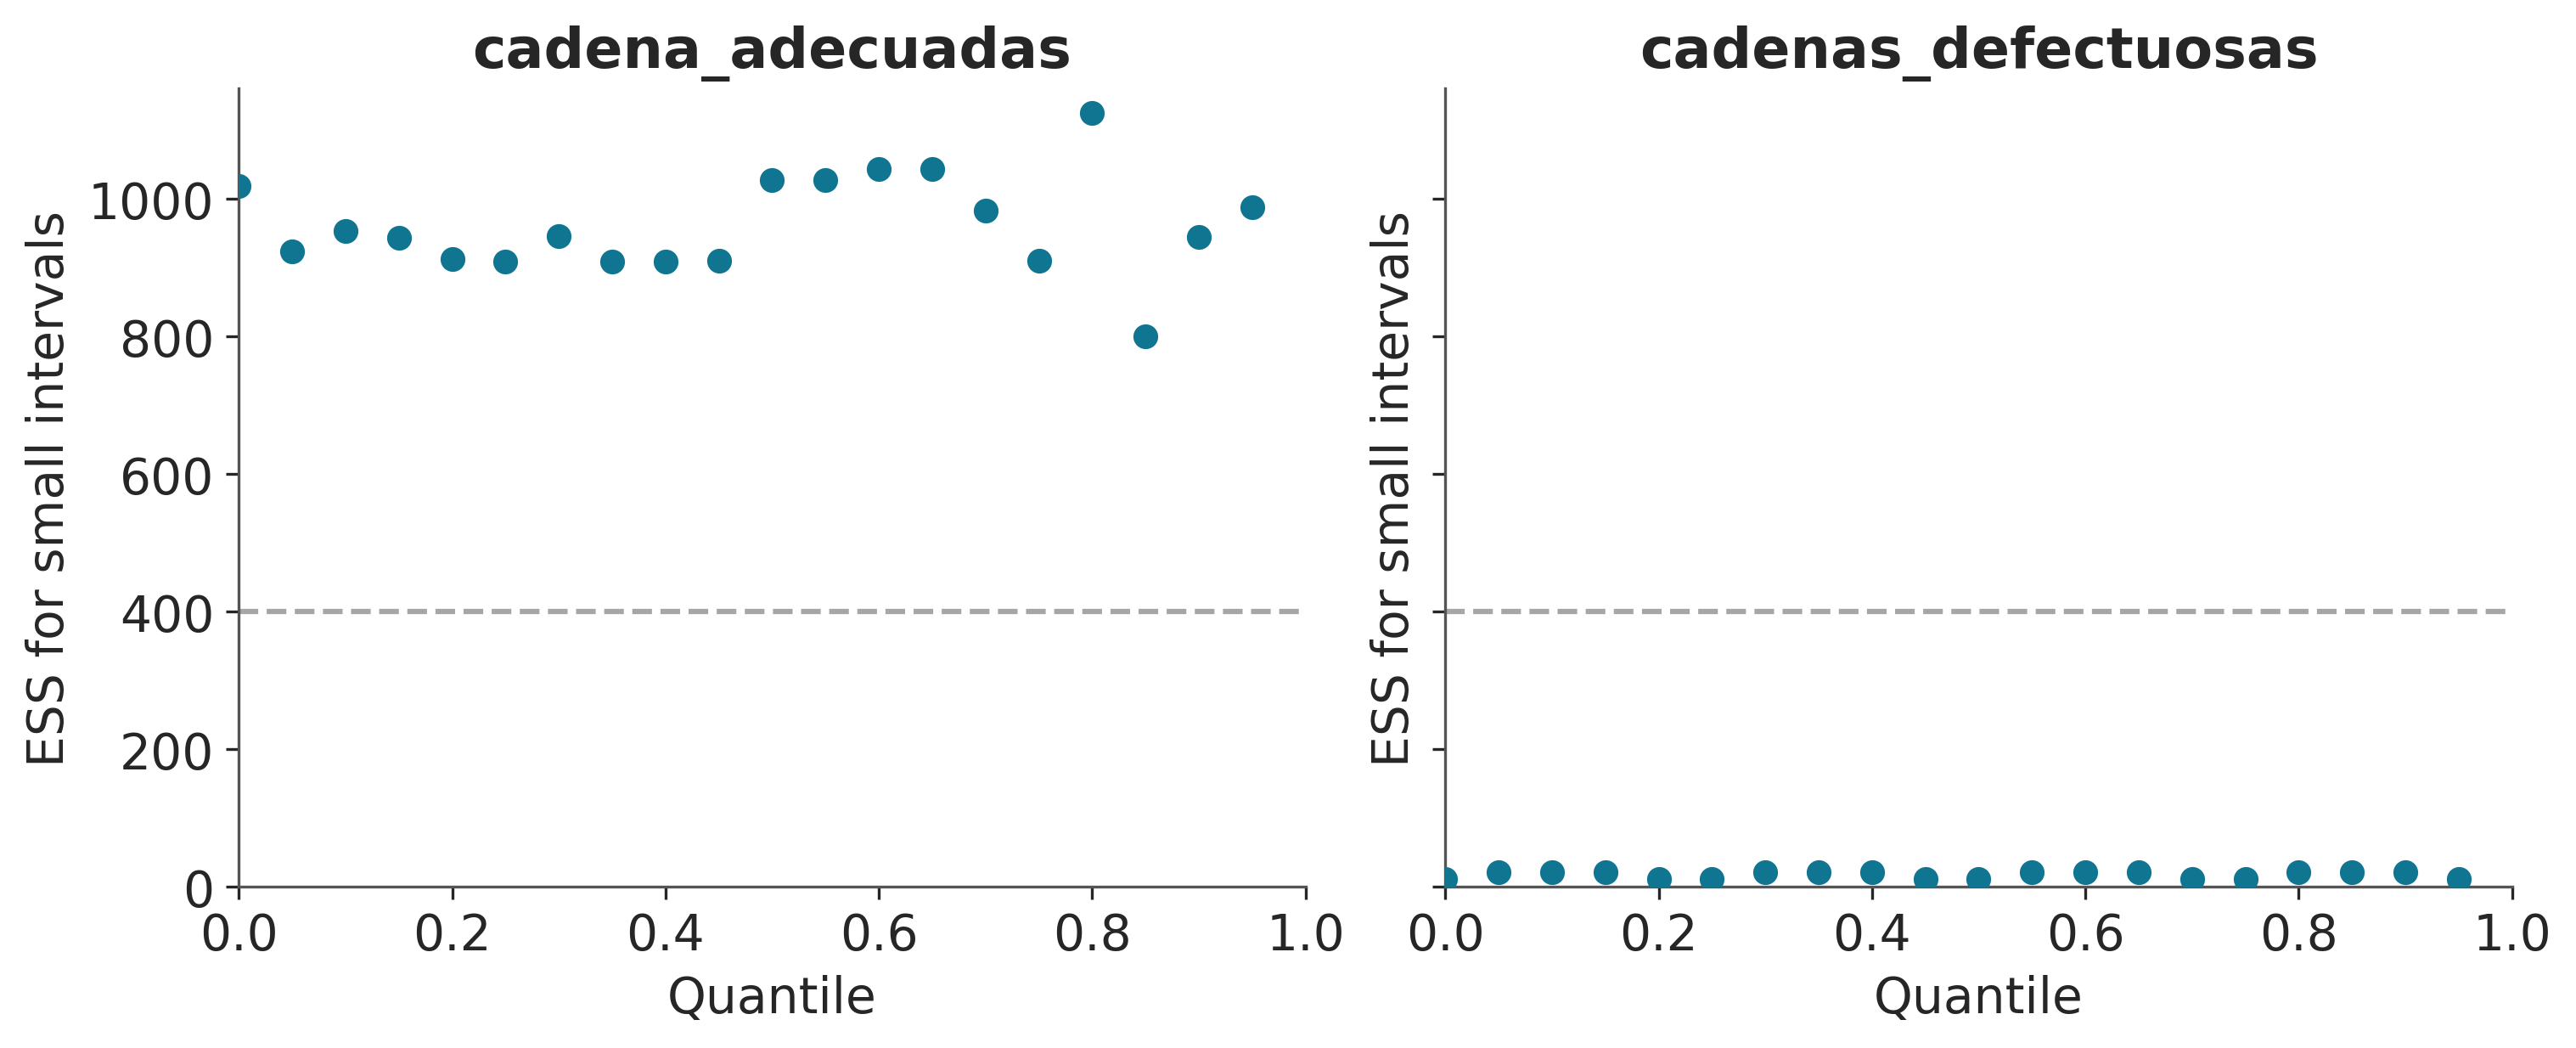

In [13]:
_, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
az.plot_ess(cadenas_adecuadas, ax=axes[0])
az.plot_ess(cadenas_defectuosas, ax=axes[1]);

Una forma simple de aumentar el ESS es aumentar la cantidad de muestras, pero podría darse el caso que el ESS crezca muy lento con el número de muestras, por lo que aún si aumentaramos 10 veces la cantidad de muestras estaríamos por debajo de lo requerido. Una forma de estimar "cuanto nos falta" es usar `az.plot_ess(⋅, kind="evolution")`. Este gráfico nos muestra como fue cambiando el ESS en muestra muestra, lo que nos permite hacer proyecciones. En el siguiente ejemplo vemos que para `cadenas_adecuadas` el ESS crece lineamente con el número de muestras mientras que para `cadenas_defectuosas` no crece para nada. Este último caso no hay esperanzas de mejorar el ESS simplemente aumentando la cantidad de muestras.

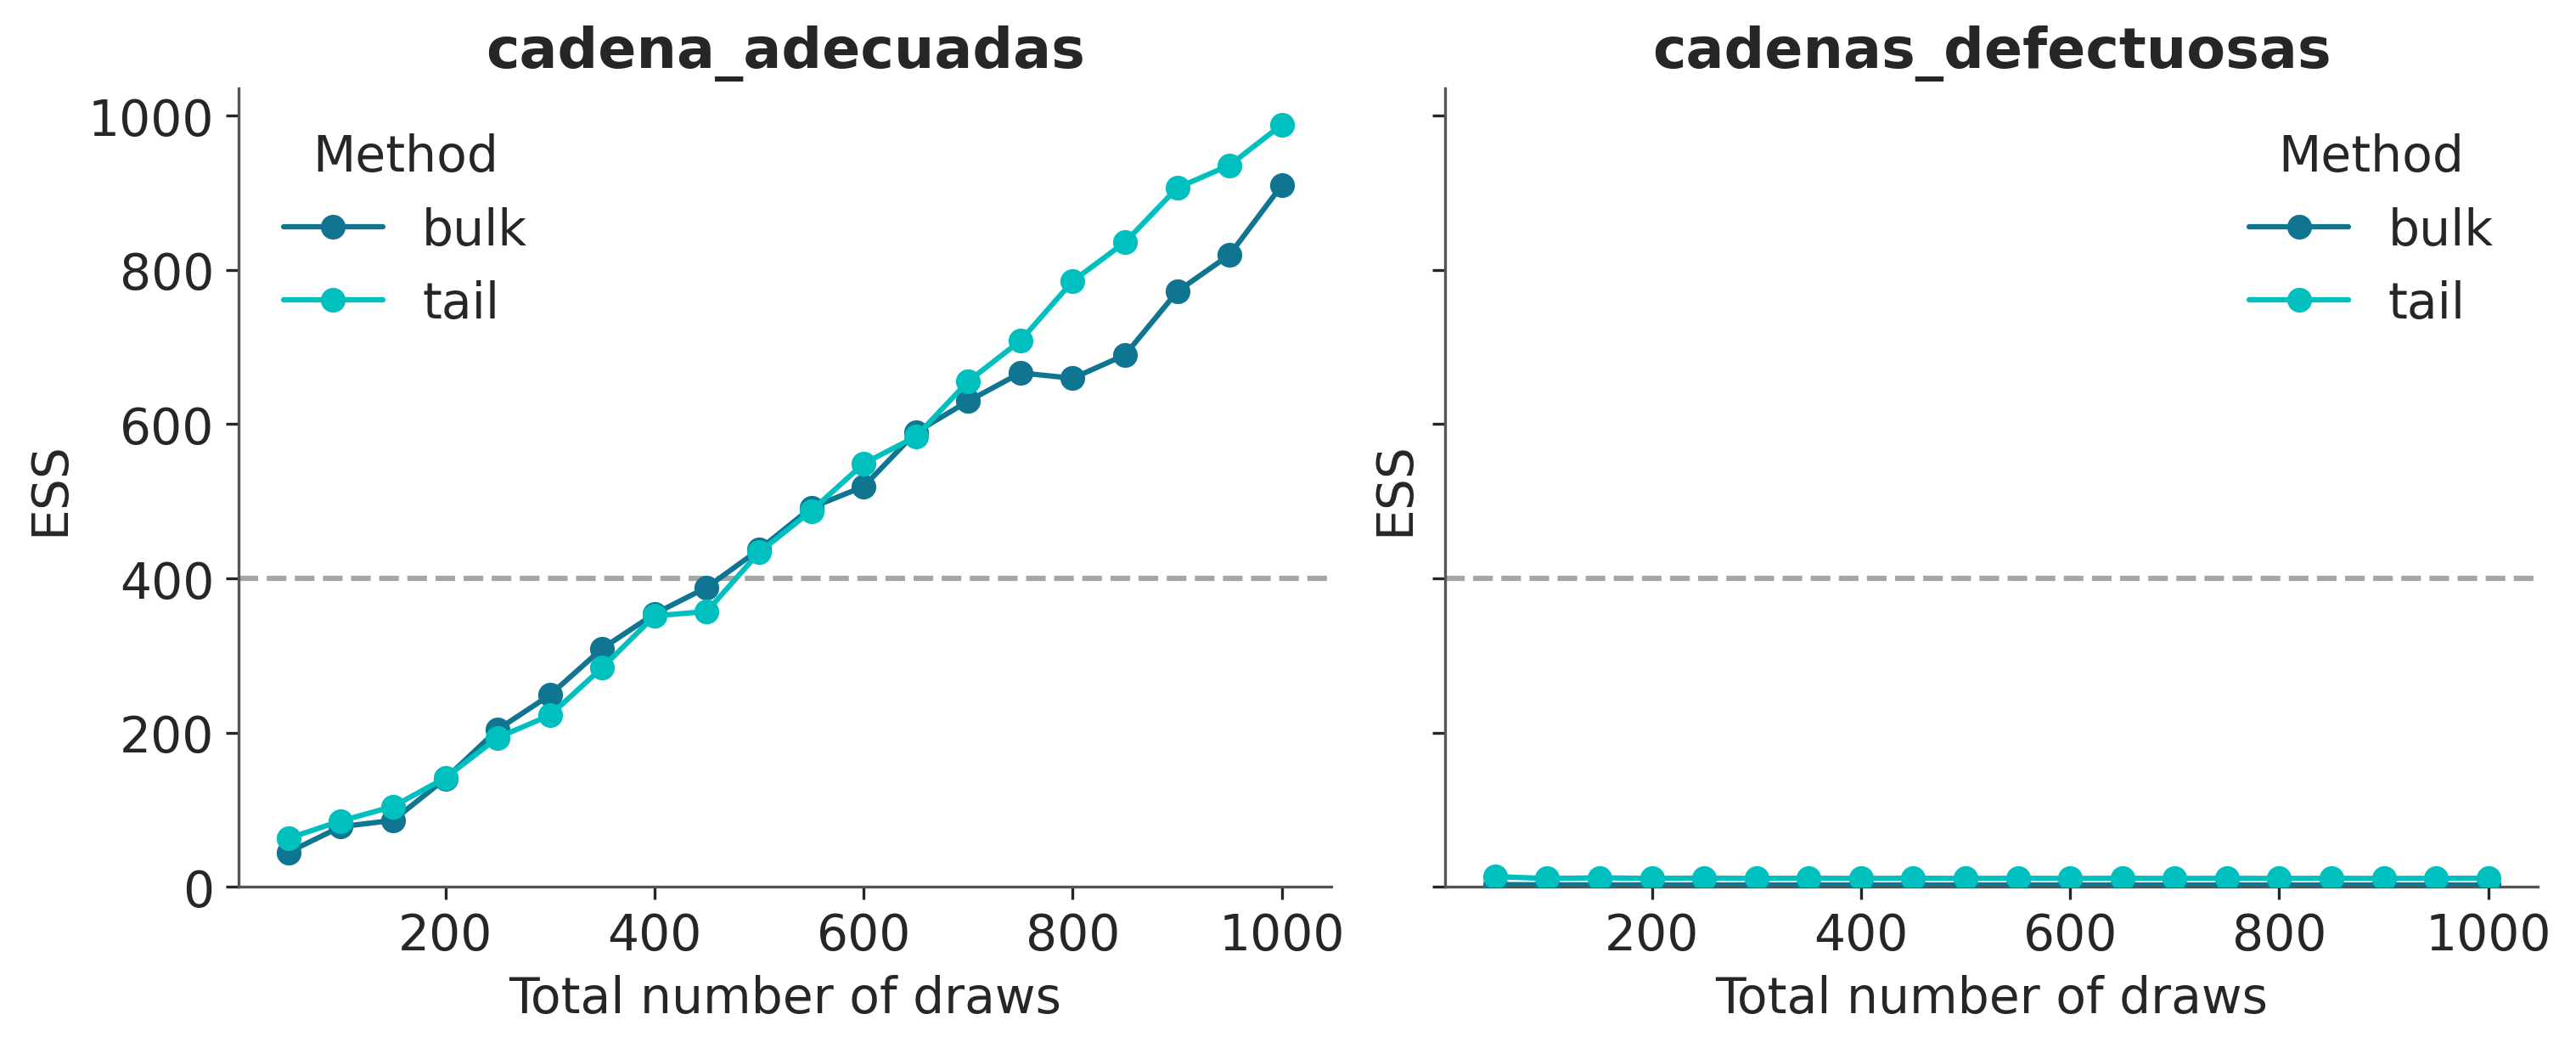

In [14]:
_, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
az.plot_ess(cadenas_adecuadas, kind="evolution", ax=axes[0])
az.plot_ess(cadenas_defectuosas,  kind="evolution", ax=axes[1]);

### Error estándard del Monte Carlo (MCSE)

Una ventaja del ESS es que no tiene escala, da igual si un parámetro varía entre 0.1 y 0.2 y otro entre -2000 y 5000, un ESS de 400 tiene el mismo significado en ambos casos. En modelos con muchos parámetros rápidamente podemos indentificar cuales parámetros son más problemáticos. Sin embargo, a la hora de reportar resultados no es muy informativo saber si el ESS fue de 1372 o 1501. En cambio nos gustaría saber el orden del error que estamos cometiendo al aproximar la distribución a posterori. Esa información la da el **error estándard del Monte Carlo** (MCSE). Al igual que el ESS, el MCSE tiene en cuenta la autocorrelación de las muestras. Este error debe estar por debajo de la precisión deseada en nuestros resultados. Es decir si para un parámetro el MCSE es 0.1, no tiene sentido reportar que la media de ese parámetro es 3.15. Ya que tranquilamente el valor correcto podría estar entre 3.4 y 2.8.

Una de las cantidades devueltas por `summary` es mc_error.

## Diagnóstico de algoritmos basados en gradiente

Debido a su funcionamiento interno, algoritmos como NUTS  ofrecen algunas pruebas específicas que no están disponibles para otros métodos. Generalmente estas pruebas son muy sensibles

Para ejemplificar esto vamos a cargar dos InferenceData de modelos pre-calculados. Los detalles de como se generaron estos idata no es relevante por el momento. Solo diremos que son dos modelos que son matemáticamente equivalente pero parametrizados de formas distintas. En este caso la parametrización afecta la eficiencia del sampler. El modelo `centrado` es muestreado de forma más eficiente que el modelo `no centrado`.

In [15]:
idata_cm = az.load_arviz_data("centered_eight")
idata_ncm = az.load_arviz_data("non_centered_eight")

### Energía de transición vs energía marginal

Podemos pensar en un Monte Carlo Hamiltoniano como un proceso de dos pasos
    * Un muestreo determinista (siguiendo el hamiltoniano)
    * Una caminata aleatorio en el espacio del momentum

Si la distribución de la energía de transición es similar a la distribución de la energía marginal, entonces NUTS es capaz de generar muestras de la distribución marginal de la energía que sean *casi* independientes entre transiciones. Esto lo podemos evaluar visualmente y numéricamente (Bayesian Fraction of Missing Information)


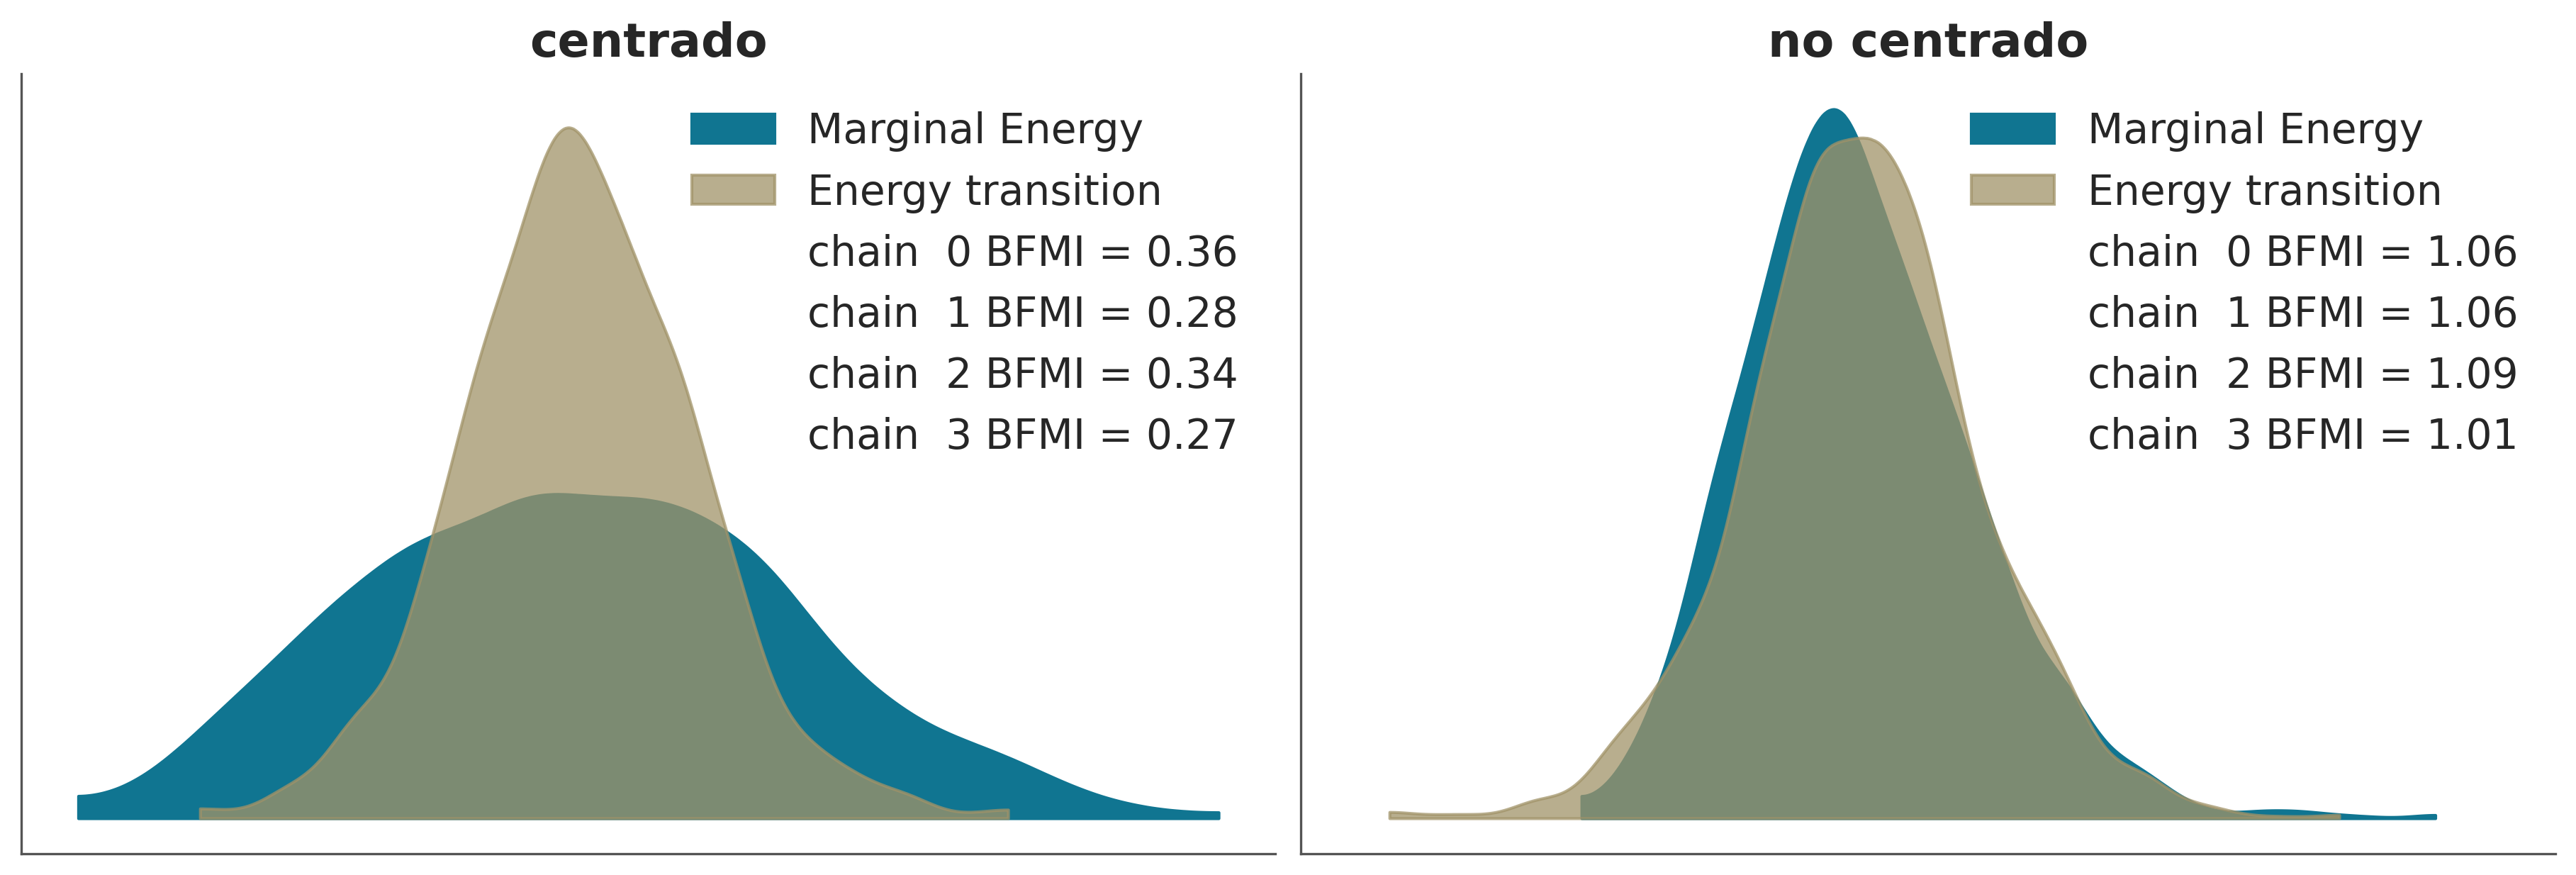

In [16]:
_, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 4), constrained_layout=True)

for ax, idata, nombre in zip(axes.ravel(), (idata_cm, idata_ncm), ("centrado", "no centrado")):
    az.plot_energy(idata, ax=ax)
    ax.set_title(nombre)

### Divergencias

Una ventaja de NUTS es que *falla con el estilo*. Esto sucede por ejemplo al intentar pasar de regiones de baja curvatura a regiones de alta curvatura. En estos casos las trayectorias numéricas pueden divergir. En esencia esto sucede por que en esos casos no existe un único conjunto de hiper-parámetros que permita el muestreo eficiente de ambas regiones. Por lo que una de la regiones es muestreada adecuandamente y cuando el sampler se mueve hacia la otra región falla. Las trayectorias numéricas divergentes son identificadores extremadamente sensibles de *vecindarios patológicos*.

El siguiente ejemplo muestra dos cosas el modelo `no centrado` muestra varias divergencias (círculos turquesas) agrupados en una región. En el modelo `centrado`, que no tiene divergencias, se puede ver que alrededor de esa misma región hay muestras para valores más pequeños de `tau`. Es decir el modelo `no centrado` falla en muestrear una región, pero al menos avisa que está teniendo problemas en muestrear esa región!

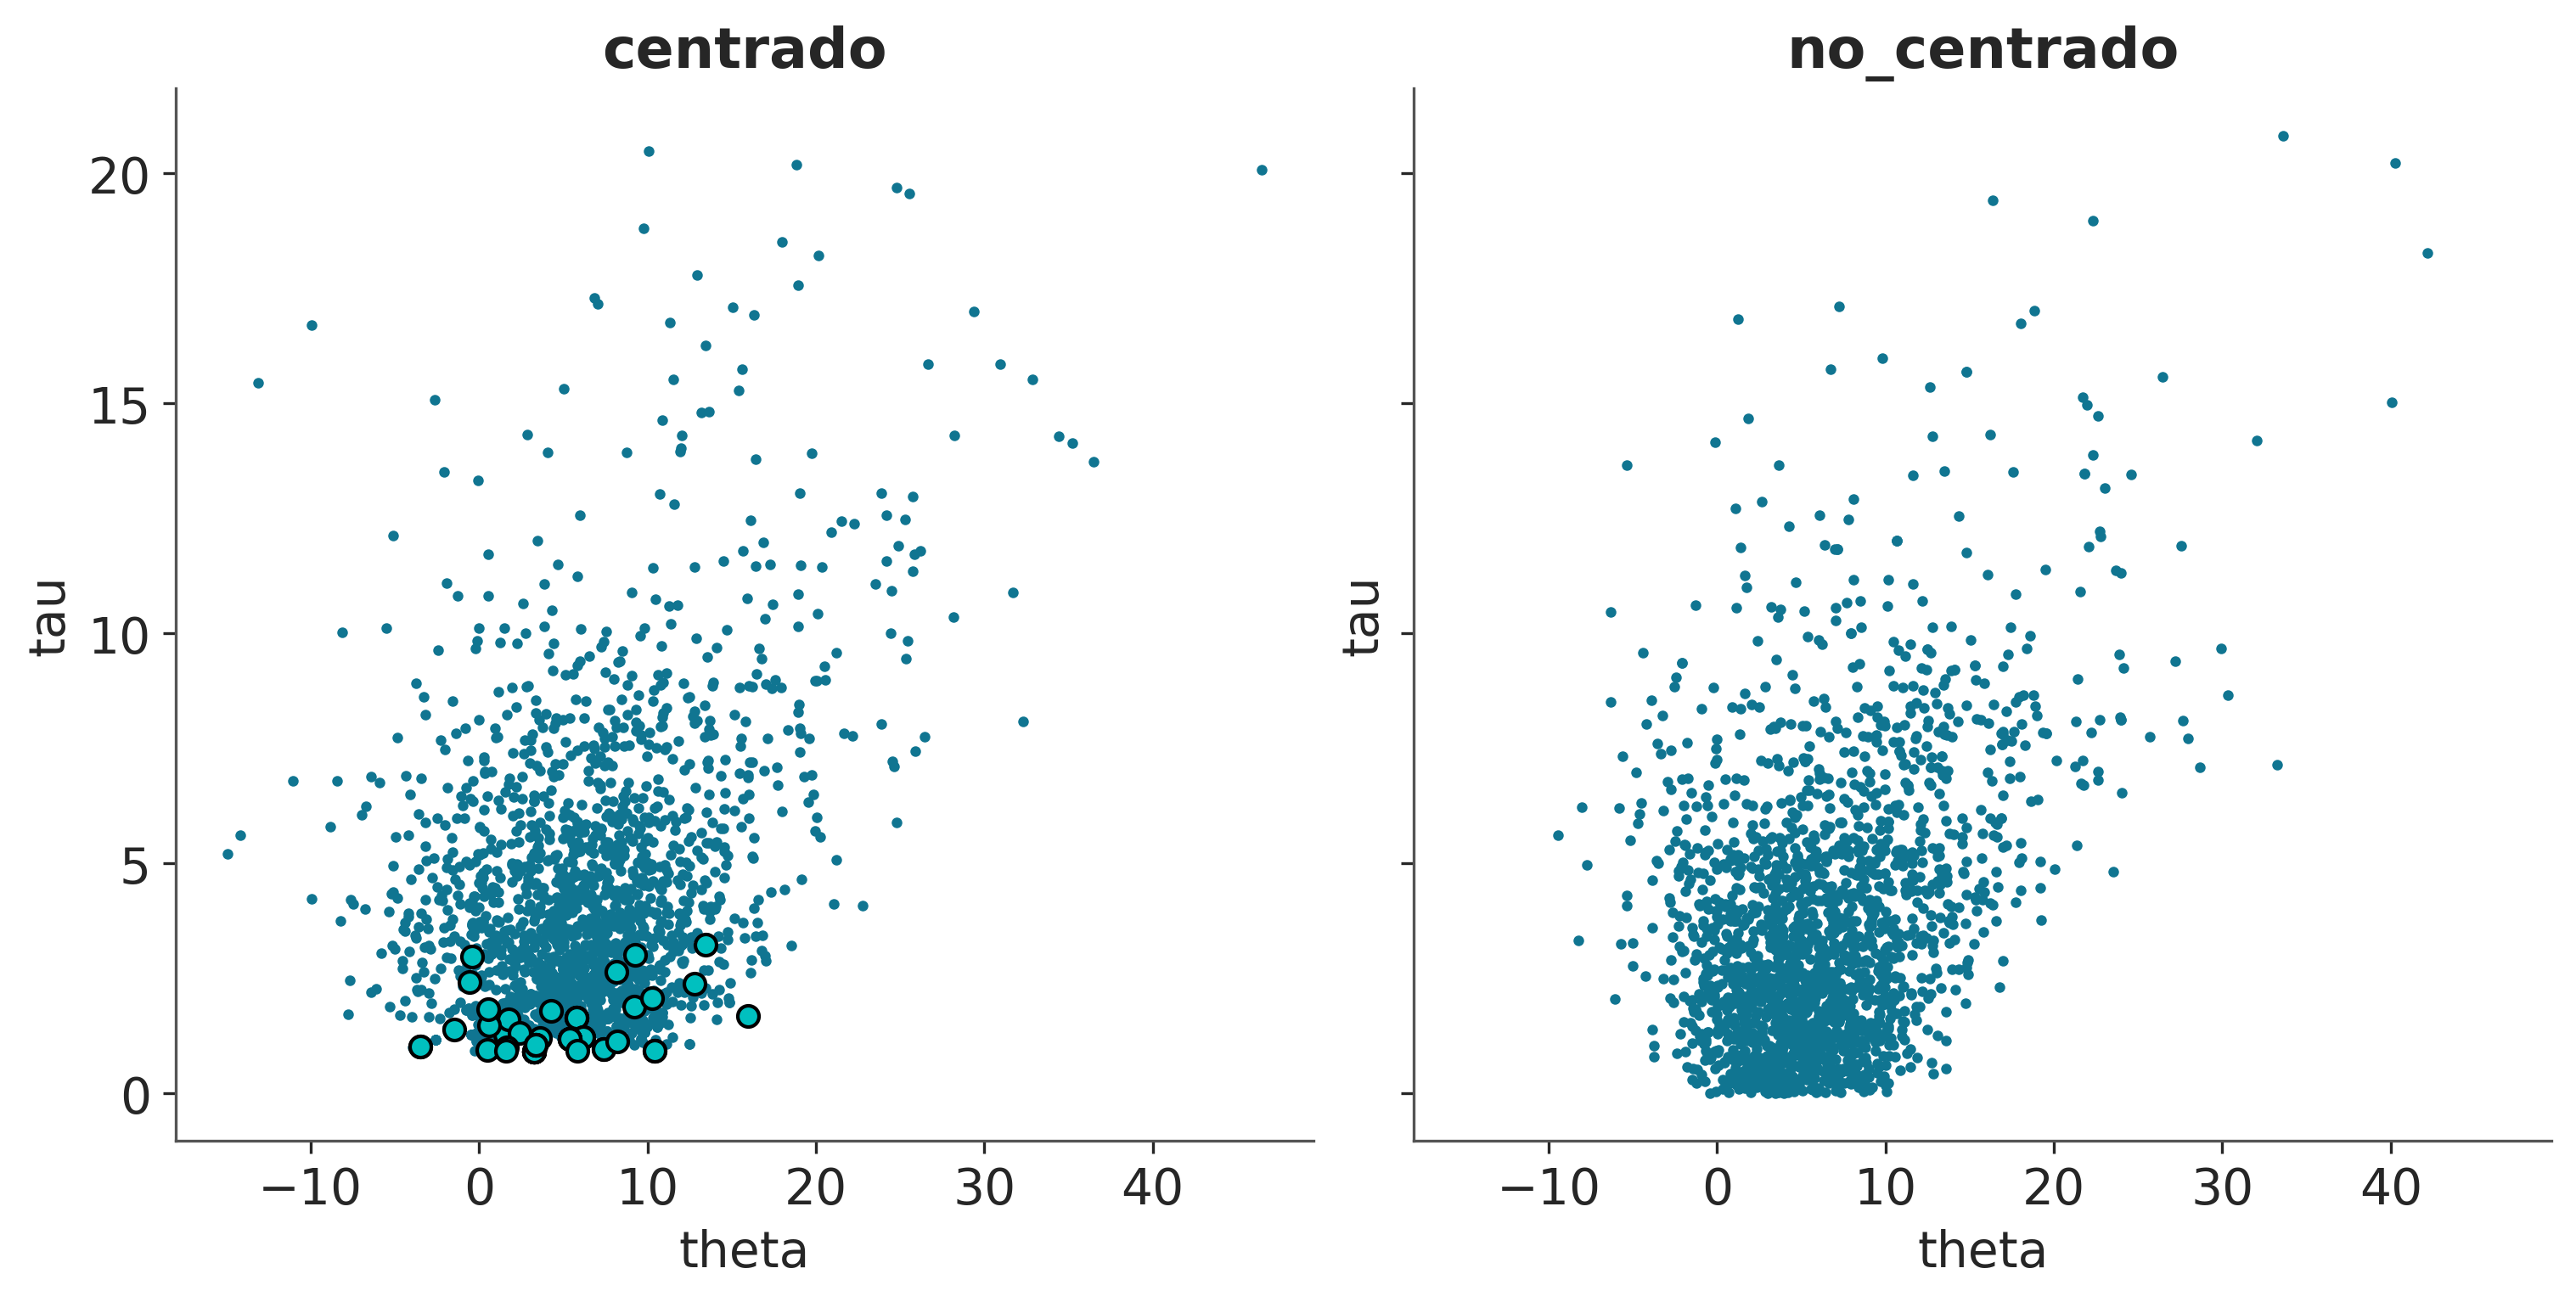

In [17]:
_, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5), constrained_layout=True)


for ax, idata, nombre in zip(axes.ravel(), (idata_cm, idata_ncm), ("centrado", "no_centrado")):
    az.plot_pair(idata, var_names=['theta', 'tau'], coords={'school':"Choate"}, kind='scatter',
                 divergences=True, divergences_kwargs={'color':'C1'},
                 ax=ax)
    ax.set_title(nombre)

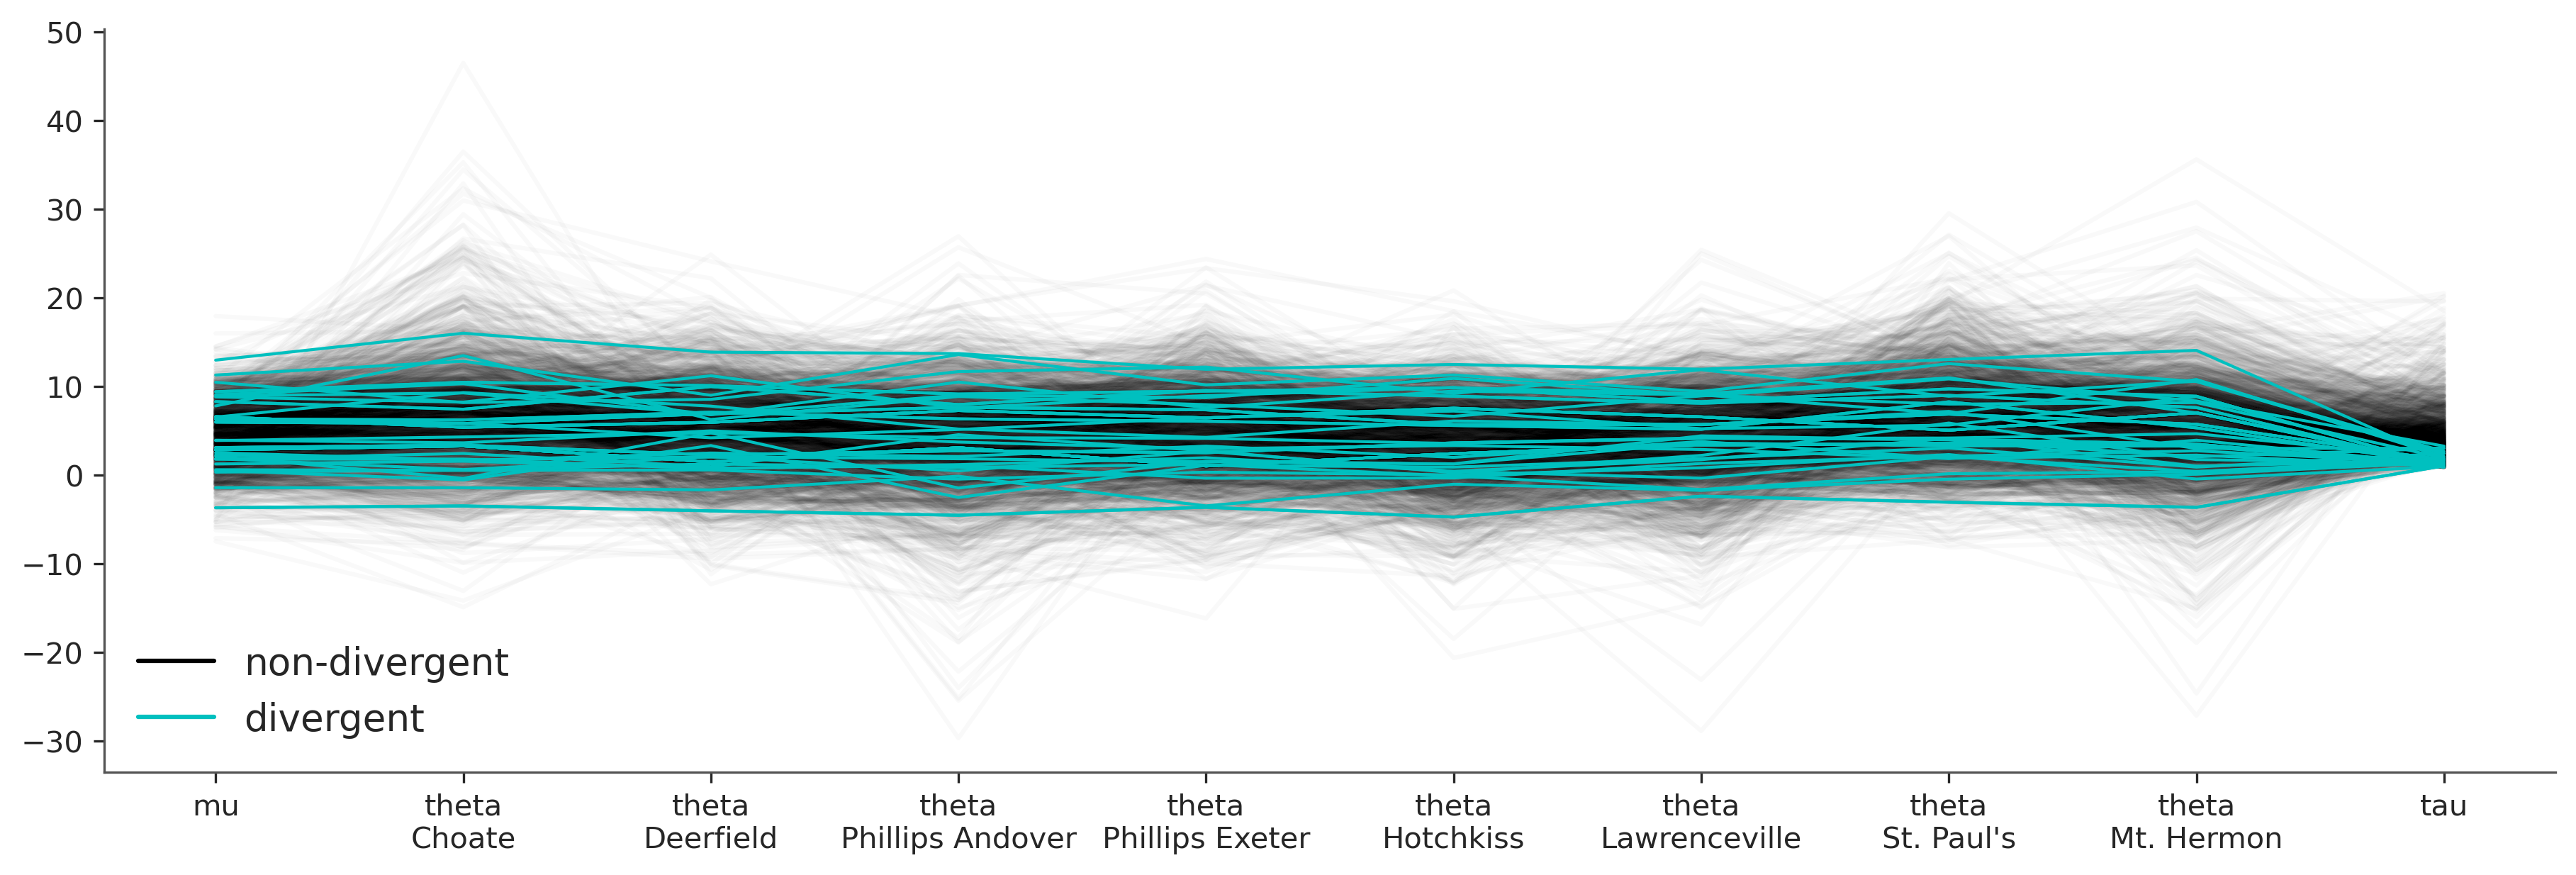

In [18]:
az.plot_parallel(idata_cm, figsize=(12, 4));

## Qué hacer cuando los diagnósticos no dan bien?

<br>

* <font color = gray> Más muestras o más pasos de tuning (aunque es dificil llegar lejos con esto) </font>

* <font color = gray> Burn-in </font>

* <font color = gray> Cambiar el método de muestreo! </font>


* Reparametrizar el modelo

* <font color = orange> Mejorar los priors </font>
    * El _teorema popular_ de la estadística computacional: Cuando tienes problemas computacionales, a menudo hay un problema con tu modelo.

* En el caso de las divergencias, estan pueden eliminarse aumentando la tasa de aceptación (`pm.sample(..., target_accept=x)` x>0.8)

* Leer los mensajes de advertencia y sugerencias de PyMC!   ;-)

## Para seguir leyendo

[Exploratory Analysis of Bayesian Models](https://github.com/arviz-devs/Exploratory-Analysis-of-Bayesian-Models/tree/master/content) Trabajo en Progreso!

[A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)

[Rank-normalization, folding, and localization](https://arxiv.org/abs/1903.08008)

[Computing Bayes: Bayesian Computation from 1763 to the 21st Century](https://arxiv.org/abs/2004.06425).